In [1]:
!nvidia-smi

import warnings
warnings.filterwarnings('ignore')

Tue Jan  2 23:29:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.01                 Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P5              13W /  20W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Helper Function

In [2]:
%run D:/Code/py_code/Convolutional-Neural-Network/experiment/widi/helper_func.py

from helper_func import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix, load_and_prep_image

# Inspect the Data

In [3]:
walk_through_dir("D:\Code\py_code\Convolutional-Neural-Network\data")

There are 2 directories and 0 images in 'D:\Code\py_code\Convolutional-Neural-Network\data'.
There are 3 directories and 0 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\test'.
There are 0 directories and 213 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\test\angry'.
There are 0 directories and 207 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\test\happy'.
There are 0 directories and 149 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\test\sad'.
There are 3 directories and 0 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\train'.
There are 0 directories and 850 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\train\angry'.
There are 0 directories and 830 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\train\happy'.
There are 0 directories and 598 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\train\sad'.


In [4]:
train_dir = r"D:\Code\py_code\Convolutional-Neural-Network\data\train"
test_dir = r"D:\Code\py_code\Convolutional-Neural-Network\data\test"

# Preprocessing the Data

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# IMG_SIZE = (100, 100)
IMG_WIDTH, IMG_HEIGHT = 224,224
BATCH_SIZE = 32
preprocess_fun = tf.keras.applications.vgg16.preprocess_input

train_datagen = ImageDataGenerator(validation_split=0.3,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_fun)

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    subset="training",
                                                    seed=42
                                                   )

validation_data = train_datagen.flow_from_directory(directory=train_dir,
                                                         target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         class_mode="categorical",
                                                         subset="validation",
                                                         seed=42
                                                        )

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=False,
                                                   class_mode="categorical",
                                                   seed=42
                                                  )

Found 1595 images belonging to 3 classes.
Found 683 images belonging to 3 classes.
Found 569 images belonging to 3 classes.


In [6]:
# import tensorflow as tf
# IMG_SIZE = (224, 224)

# train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
#                                                                 color_mode = "rgb",
#                                                                 label_mode="categorical",
#                                                                 image_size=IMG_SIZE)
                                                                                
# test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
#                                                                 label_mode="categorical",
#                                                                 color_mode = "rgb",
#                                                                 image_size=IMG_SIZE,
#                                                                 shuffle=False) 

In [7]:
import pathlib
import numpy as np

data_dir = pathlib.Path(train_dir) 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) 
print(class_names)

['angry' 'happy' 'sad']


In [8]:
checkpoint_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

In [9]:
# # Create checkpoint callback to save model for later use
# checkpoint_path = "101_classes_10_percent_data_model_checkpointt"
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
#                                                          save_weights_only=True, 
#                                                          monitor="val_accuracy", 
#                                                          save_best_only=True)

In [10]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  preprocessing.Rescaling(1./255)
], name ="data_augmentation")

In [11]:
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, 
                                                            weights="imagenet", 
                                                            input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.Dropout(0.3)(x)
# x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.Dropout(0.2)(x) 
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x) 
model = tf.keras.Model(inputs, outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling (Gl  (None, 2048)              0         
 obalAveragePooling2D)                                           
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192  

In [13]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data,
                                           epochs=10,
                                           validation_data=validation_data,
                                           validation_steps=int(0.15 * len(validation_data)), 
                                           callbacks=[checkpoint_callback])

Epoch 1/10


50/50 [==============================] - 59s 1s/step - loss: 6.0402 - accuracy: 0.4865 - val_loss: 4.9655 - val_accuracy: 0.5521
Epoch 2/10
50/50 [==============================] - 34s 660ms/step - loss: 4.8985 - accuracy: 0.5887 - val_loss: 4.0184 - val_accuracy: 0.6875
Epoch 3/10
50/50 [==============================] - 28s 561ms/step - loss: 4.1666 - accuracy: 0.5749 - val_loss: 3.5836 - val_accuracy: 0.6250
Epoch 4/10
50/50 [==============================] - 28s 554ms/step - loss: 3.4749 - accuracy: 0.6376 - val_loss: 3.1309 - val_accuracy: 0.5938
Epoch 5/10
50/50 [==============================] - 56s 1s/step - loss: 2.9776 - accuracy: 0.6370 - val_loss: 2.6696 - val_accuracy: 0.6979
Epoch 6/10
50/50 [==============================] - 56s 1s/step - loss: 2.5578 - accuracy: 0.6502 - val_loss: 2.3236 - val_accuracy: 0.6458
Epoch 7/10
50/50 [==============================] - 63s 1s/step - loss: 2.2651 - accuracy: 0.6539 - val_loss: 2.0009 - val_accuracy: 0.6771
Epoch 8/1

In [14]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

18/18 [==============================] - 18s 989ms/step - loss: 1.5957 - accuracy: 0.6397


[1.5956753492355347, 0.6397188305854797]

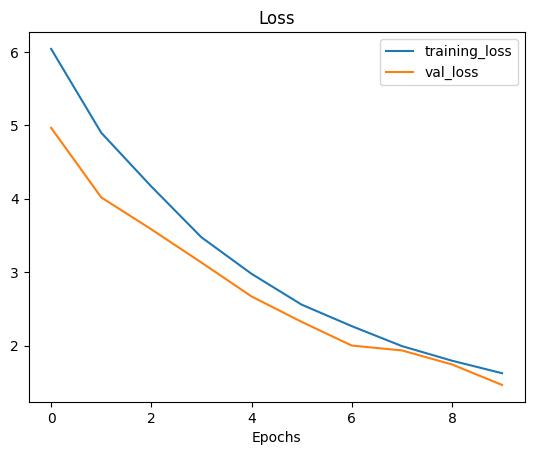

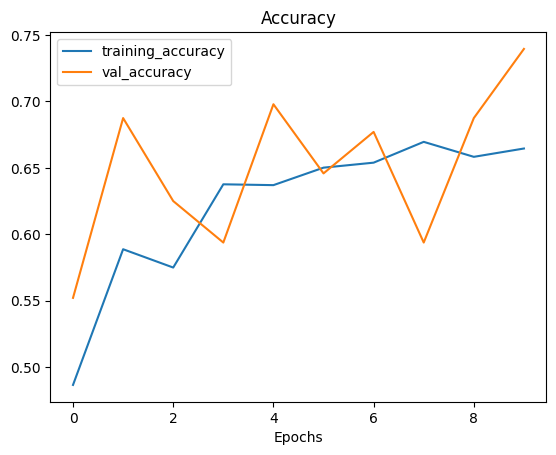

In [15]:
plot_loss_curves(history_all_classes_10_percent)

# Fine tunning

In [16]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
# for layer in base_model.layers[:-5]:
#   layer.trainable = False

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [18]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
inception_v3 True
global_average_pooling True
flatten True
batch_normalization_94 True
dense True
dropout True
output_layer True


In [19]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 True
1 conv2d True
2 batch_normalization True
3 activation True
4 conv2d_1 True
5 batch_normalization_1 True
6 activation_1 True
7 conv2d_2 True
8 batch_normalization_2 True
9 activation_2 True
10 max_pooling2d True
11 conv2d_3 True
12 batch_normalization_3 True
13 activation_3 True
14 conv2d_4 True
15 batch_normalization_4 True
16 activation_4 True
17 max_pooling2d_1 True
18 conv2d_8 True
19 batch_normalization_8 True
20 activation_8 True
21 conv2d_6 True
22 conv2d_9 True
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 True
26 activation_9 True
27 average_pooling2d True
28 conv2d_5 True
29 conv2d_7 True
30 conv2d_10 True
31 conv2d_11 True
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 True
37 activation_7 True
38 activation_10 True
39 activation_11 True
40 mixed0 True
41 conv2d_15 True
42 batch_normalization_15 True
43 activation_15 True
44 conv2d_13 True
45

In [20]:
fine_tune_epochs = 20 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=validation_data,
                                                     validation_steps=int(0.15 * len(validation_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 10/20


50/50 [==============================] - 265s 5s/step - loss: 1.8060 - accuracy: 0.5179 - val_loss: 3.4888 - val_accuracy: 0.2812
Epoch 11/20
50/50 [==============================] - 141s 3s/step - loss: 1.5646 - accuracy: 0.6514 - val_loss: 1.5645 - val_accuracy: 0.6146
Epoch 12/20
50/50 [==============================] - 157s 3s/step - loss: 1.4717 - accuracy: 0.6828 - val_loss: 2.7270 - val_accuracy: 0.4792
Epoch 13/20
50/50 [==============================] - 142s 3s/step - loss: 1.3550 - accuracy: 0.7116 - val_loss: 1.8297 - val_accuracy: 0.5521
Epoch 14/20
18/50 [=========>....................] - ETA: 1:38 - loss: 1.3481 - accuracy: 0.7274

In [ ]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

18/18 [==============================] - 1s 69ms/step - loss: 1.0444 - accuracy: 0.6995


[1.0443657636642456, 0.6994727849960327]

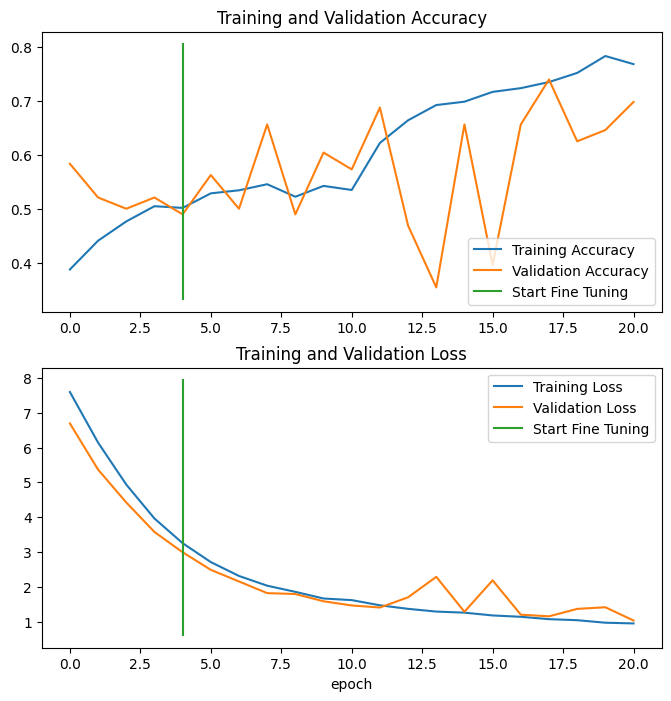

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [ ]:
pred_probs = model.predict(test_data, verbose=1)
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

18/18 [==============================] - 3s 71ms/step


array([0, 2, 0, 2, 0, 0, 1, 0, 0, 0], dtype=int64)

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = test_data.labels
# for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
#   y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Evaluating the Model

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6994727592267135

In [ ]:
# Get the class names
# class_names = test_data.class_names
class_names[:10]

array(['angry', 'happy', 'sad'], dtype='<U5')

In [ ]:
# # Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
# make_confusion_matrix(y_true=y_labels,
#                       y_pred=pred_classes,
#                       classes=class_names,
#                       figsize=(20, 20),
#                       text_size=20,
#                       norm=False, 
#                       savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.81      0.62      0.71       213
           1       0.72      0.82      0.76       207
           2       0.56      0.64      0.60       149

    accuracy                           0.70       569
   macro avg       0.70      0.70      0.69       569
weighted avg       0.71      0.70      0.70       569



In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.8109756097560976,
  'recall': 0.6244131455399061,
  'f1-score': 0.7055702917771884,
  'support': 213.0},
 '1': {'precision': 0.7191489361702128,
  'recall': 0.8164251207729468,
  'f1-score': 0.7647058823529413,
  'support': 207.0},
 '2': {'precision': 0.5647058823529412,
  'recall': 0.6442953020134228,
  'f1-score': 0.6018808777429466,
  'support': 149.0},
 'accuracy': 0.6994727592267135,
 'macro avg': {'precision': 0.6982768094264172,
  'recall': 0.6950445227754253,
  'f1-score': 0.6907190172910255,
  'support': 569.0},
 'weighted avg': {'precision': 0.7130805116623393,
  'recall': 0.6994727592267135,
  'f1-score': 0.6999311785224939,
  'support': 569.0}}

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'angry': 0.7055702917771884,
 'happy': 0.7647058823529413,
 'sad': 0.6018808777429466}

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

,class_name,f1-score
1,happy,0.764706
0,angry,0.705570
2,sad,0.601881


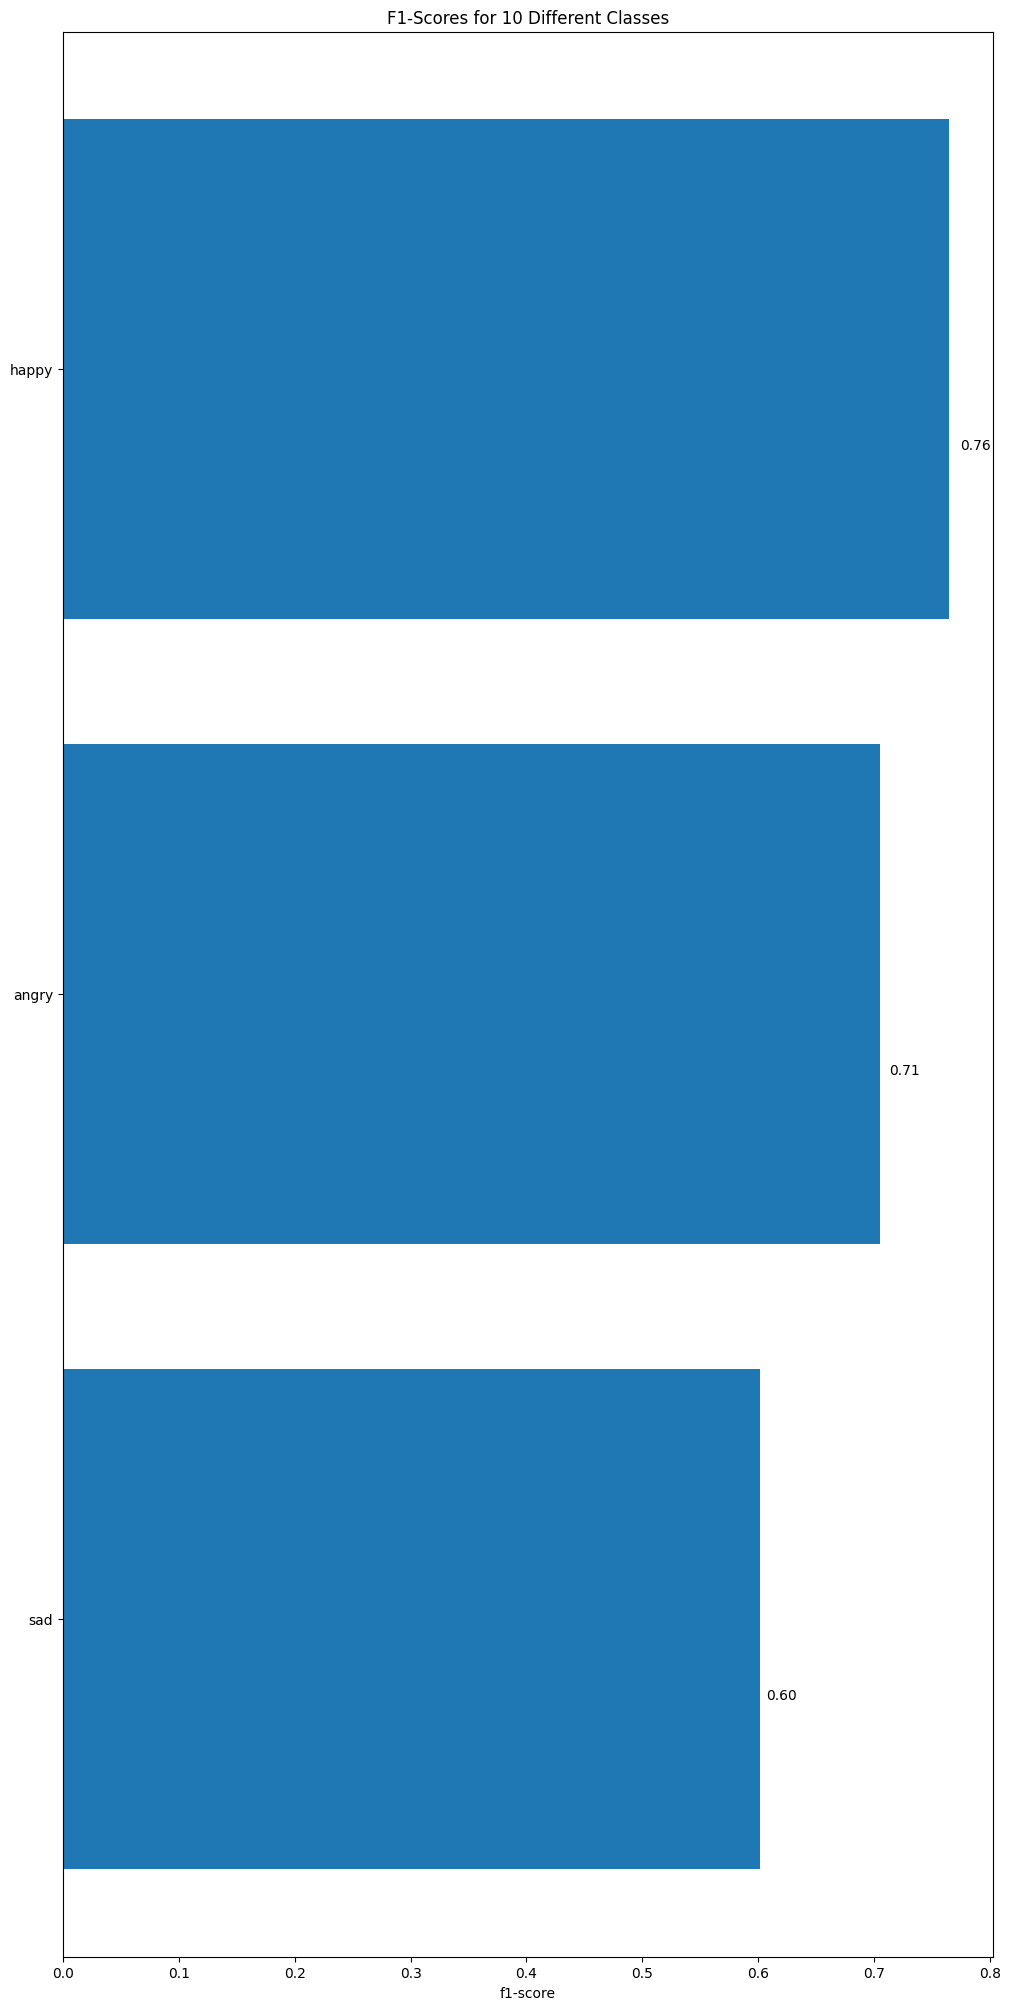

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

# Predict on an image

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, img_shape=IMG_WIDTH ,scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

ValueError: in user code:

    File "c:\anaconda3\envs\tf-env\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\anaconda3\envs\tf-env\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\anaconda3\envs\tf-env\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\anaconda3\envs\tf-env\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\anaconda3\envs\tf-env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\anaconda3\envs\tf-env\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 100, 100, 3), found shape=(None, 224, 224, 3)


<Figure size 1700x1000 with 0 Axes>

# Get most Wrong

In [ ]:
# 1. Get the filenames of all of our test data
filepaths = test_data.filepaths
# for filepath in test_data.list_files(r"D:\Code\py_code\Convolutional-Neural-Network\data\test\*\*.jpg", 
#                                      shuffle=False):
#   filepaths.append(filepath.numpy())
filepaths[:10]

['D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\1.jpg',
 'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\101.jpg',
 'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\1012.jpg',
 'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\1016.jpg',
 'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\1018.jpg',
 'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\102.jpg',
 'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\1025.jpg',
 'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\1028.jpg',
 'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\103.jpg',
 'D:\\Code\\py_code\\Convolutional-Neural-Network\\data\\test\\angry\\1030.jpg']

In [ ]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,D:\Code\py_code\Convolutional-Neural-Network\d...,0,0,0.958519,angry,angry
1,D:\Code\py_code\Convolutional-Neural-Network\d...,0,2,0.349846,angry,sad
2,D:\Code\py_code\Convolutional-Neural-Network\d...,0,0,0.961676,angry,angry
3,D:\Code\py_code\Convolutional-Neural-Network\d...,0,2,0.619420,angry,sad
4,D:\Code\py_code\Convolutional-Neural-Network\d...,0,0,0.688899,angry,angry


In [ ]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,D:\Code\py_code\Convolutional-Neural-Network\d...,0,0,0.958519,angry,angry,True
1,D:\Code\py_code\Convolutional-Neural-Network\d...,0,2,0.349846,angry,sad,False
2,D:\Code\py_code\Convolutional-Neural-Network\d...,0,0,0.961676,angry,angry,True
3,D:\Code\py_code\Convolutional-Neural-Network\d...,0,2,0.619420,angry,sad,False
4,D:\Code\py_code\Convolutional-Neural-Network\d...,0,0,0.688899,angry,angry,True


In [ ]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
349,D:\Code\py_code\Convolutional-Neural-Network\d...,1,0,0.993533,happy,angry,False
538,D:\Code\py_code\Convolutional-Neural-Network\d...,2,0,0.990062,sad,angry,False
166,D:\Code\py_code\Convolutional-Neural-Network\d...,0,1,0.984068,angry,happy,False
436,D:\Code\py_code\Convolutional-Neural-Network\d...,2,1,0.982003,sad,happy,False
105,D:\Code\py_code\Convolutional-Neural-Network\d...,0,1,0.965574,angry,happy,False
126,D:\Code\py_code\Convolutional-Neural-Network\d...,0,1,0.944100,angry,happy,False
554,D:\Code\py_code\Convolutional-Neural-Network\d...,2,1,0.935755,sad,happy,False
170,D:\Code\py_code\Convolutional-Neural-Network\d...,0,2,0.927906,angry,sad,False
442,D:\Code\py_code\Convolutional-Neural-Network\d...,2,1,0.922627,sad,happy,False
398,D:\Code\py_code\Convolutional-Neural-Network\d...,1,0,0.920817,happy,angry,False


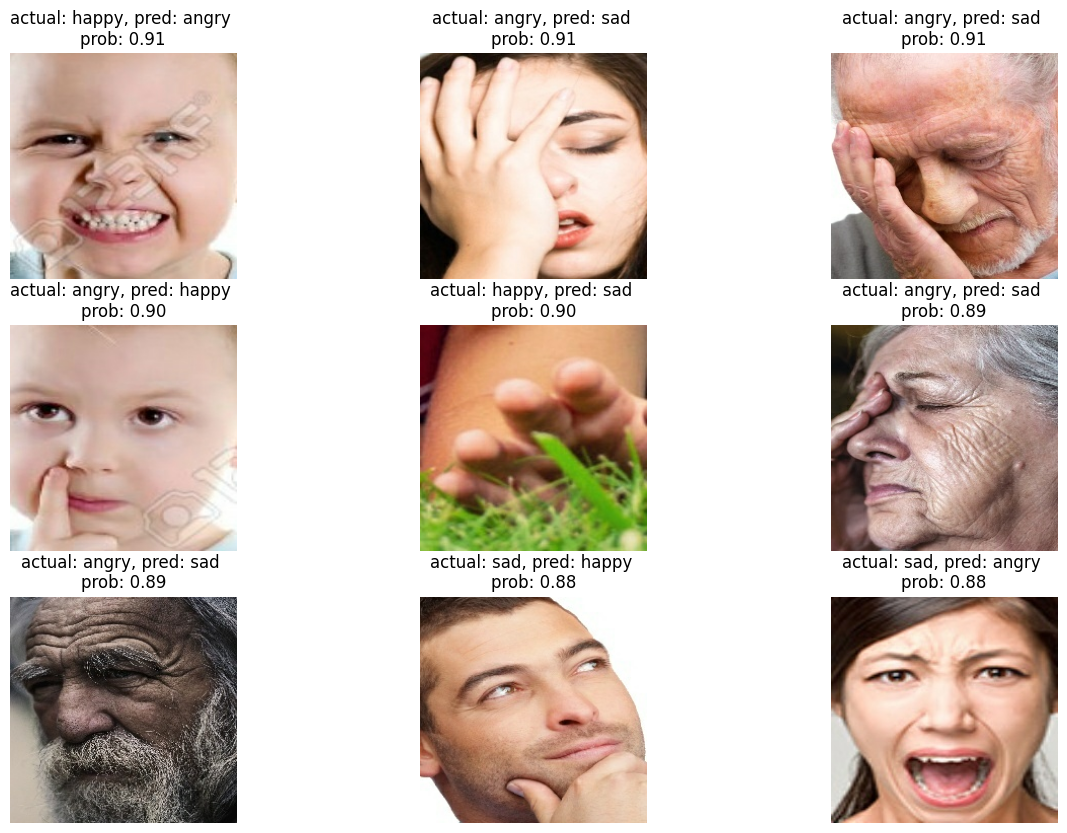

In [ ]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)